# Анализ системы метрик приложения Procrastinate Pro+

* Автор: Игнатьев Валерий
* Дата: 31.01.2026

### Цели и задачи анализа

**Цель:** Определить факторы, повлиявшие на отсутствие роста доходов при увеличении интереса к приложению Procrastinate Pro+ после введения спортивного контента и пересмотра маркетинговой стратегии (Таргет выхода на самоокупаемость привлечения - в первые 28 дней).

**Задачи:** 
- Провести анализ юнит-экономики продукта в динамике за первые 28 дней;
- Разобраться в причинах стагнации выручки;
- Определить, какие источники привлечения приносят прибыль, а какие не выходят на уровень окупаемости;
- Выводы и рекомендации по результатам исследования для отдела маркетинга.

### Описание данных

* **Датасет `ppro_visits.csv`** — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.


* **Датасет `ppro_orders.csv`** — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.



* **Датасет `ppro_costs.csv`** — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.


### Содержимое анализа

- Загрузка и предобработка данных;
- Подготовка данных и датасетов для когортного анализа;
- Анализ и вычисление показателей вовлечённости пользователей в продукт;
- Анализ и вычисление финансовых метрик CAC, LTV и ROI за первые 28 дней с момента привлечения;
- Исследование метрик в разрезе источников привлечения;
- Анализ и вычисление периода окупаемости маркетинговых вложений;
- Формулирование выводов и гипотез.

## Загрузка и предобработка данных

Загрузка данных и знакомство с ними. Предобработка данных для дальнейших вычислений и оптимизации

In [1]:
# Импортируем необходимые для анализа библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

In [2]:
# Загружаем датасеты и знакомимся с ними
visits_df = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_visits.csv', parse_dates=['session_start','session_end'])
orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_orders.csv',parse_dates=['event_dt'])
costs_df = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_costs.csv',parse_dates=['dt']) 

#### Знакомство с данными

In [3]:
visits_df.info()
visits_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        161865 non-null  int64         
 1   region         161865 non-null  object        
 2   device         161865 non-null  object        
 3   channel        161865 non-null  object        
 4   session_start  161865 non-null  datetime64[ns]
 5   session_end    161865 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 7.4+ MB


,user_id,region,device,channel,session_start,session_end
14044,17960720167,India,mobile,TipTop,2024-04-29 10:00:00,2024-04-29 10:40:00
97597,730967068187,India,desktop,RocketSuperAds,2024-09-12 21:52:00,2024-09-12 22:29:00
42497,235821051503,India,desktop,RocketSuperAds,2024-06-19 23:14:00,2024-06-19 23:19:00
41424,422027655949,India,desktop,FaceBoom,2024-06-17 23:42:00,2024-06-17 23:44:00
10975,291779193133,India,desktop,MediaTornado,2024-04-23 06:19:00,2024-04-23 06:38:00


Датафрейм  **`visits_df`** содержит 6 колонок и 161 865 строк:
* В данных отсутствуют NaN значения
* Тип данных в колонках `region`, `device`, `channel` можно преобразовать в `category` для оптимизации ресурсов во время расчетов

In [4]:
orders_df.info()
orders_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   33893 non-null  int64         
 1   event_dt  33893 non-null  datetime64[ns]
 2   revenue   33893 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 794.5 KB


,user_id,event_dt,revenue
9925,869987145482,2024-07-20 19:18:53,2.99
13782,98109210986,2024-08-15 07:05:48,2.99
6610,484659689426,2024-06-22 00:20:54,2.99
12978,880772403114,2024-08-10 23:55:19,2.99
3992,214407809296,2024-05-27 19:37:14,2.99


Датафрейм  **`orders_df`** содержит 3 колонки и 33 893 строки:
* В данных отсутствуют NaN значения
* Тип данных в колонках `revenue` корректен, но можно уменьшить разрядность для оптимизации ресурсов

In [5]:
costs_df.info()
costs_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       976 non-null    datetime64[ns]
 1   channel  976 non-null    object        
 2   costs    976 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.0+ KB


,dt,channel,costs
588,2024-07-10,RocketSuperAds,25.585000
165,2024-09-13,FaceBoom,169.747689
234,2024-11-21,FaceBoom,166.473846
193,2024-10-11,FaceBoom,122.953205
812,2024-06-20,TipTop,92.327480


Датафрейм  **`costs_df`** содержит 3 колонки и 976 строк:
* В данных отсутствуют NaN значения
* Тип данных в колонках `costs` корректен, но можно уменьшить разрядность для оптимизации ресурсов

#### Предобработка данных

In [6]:
# Создаем словарь DF - имя столбца для быстрого преобразования в форматы
categorys = ['region', 'device', 'channel']

# Уменьшим разрядность
costs_df['costs'] = pd.to_numeric(costs_df['costs'], errors='coerce', downcast='float')
orders_df['revenue'] = pd.to_numeric(orders_df['revenue'], errors='coerce', downcast='float')
    
# Обработаем формат категория
for category in categorys:
    visits_df[category] = visits_df[category].astype('category')
    
    
visits_df.info()
display("----------------------------")
costs_df.info()
display("----------------------------")
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        161865 non-null  int64         
 1   region         161865 non-null  category      
 2   device         161865 non-null  category      
 3   channel        161865 non-null  category      
 4   session_start  161865 non-null  datetime64[ns]
 5   session_end    161865 non-null  datetime64[ns]
dtypes: category(3), datetime64[ns](2), int64(1)
memory usage: 4.2 MB


'----------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       976 non-null    datetime64[ns]
 1   channel  976 non-null    object        
 2   costs    976 non-null    float32       
dtypes: datetime64[ns](1), float32(1), object(1)
memory usage: 19.2+ KB


'----------------------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   33893 non-null  int64         
 1   event_dt  33893 non-null  datetime64[ns]
 2   revenue   33893 non-null  float32       
dtypes: datetime64[ns](1), float32(1), int64(1)
memory usage: 662.1 KB


#### Аномальные значения

In [7]:
# Изучим детально все возможные значения в колонках visits_df
columns = ['region', 'device', 'channel']
for column in columns:
    display(visits_df[column].unique())

['India']
Categories (1, object): ['India']

['desktop', 'tv', 'mobile']
Categories (3, object): ['desktop', 'tv', 'mobile']

['MediaTornado', 'RocketSuperAds', 'FaceBoom', 'TipTop']
Categories (4, object): ['MediaTornado', 'RocketSuperAds', 'FaceBoom', 'TipTop']

In [8]:
# Изучим уникальные каналы в costs_df
costs_df['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop'],
      dtype=object)

In [9]:
# Изучим распределение дат в visits_df
visits_df[['session_start', 'session_end']].describe(datetime_is_numeric=True)

,session_start,session_end
count,161865,161865
mean,2024-08-13 00:20:43.344639232,2024-08-13 00:50:48.320637696
min,2024-04-01 00:07:00,2024-04-01 00:22:00
25%,2024-06-16 01:27:00,2024-06-16 02:01:00
50%,2024-08-18 10:58:00,2024-08-18 11:37:00
75%,2024-10-13 05:19:00,2024-10-13 05:54:00
max,2024-11-30 23:59:00,2024-12-01 01:40:00


In [10]:
# Изучим распределение дат и костов в costs_df
costs_df[['dt', 'costs']].describe(datetime_is_numeric=True)

,dt,costs
count,976,976.000000
mean,2024-07-31 12:00:00,81.691910
min,2024-04-01 00:00:00,9.048985
25%,2024-05-31 18:00:00,19.546202
50%,2024-07-31 12:00:00,54.282076
75%,2024-09-30 06:00:00,134.499069
max,2024-11-30 00:00:00,316.923431
std,NaN,70.237686


In [11]:
# Изучим распределение дат и выручки в orders_df
orders_df[['event_dt', 'revenue']].describe(datetime_is_numeric=True)

,event_dt,revenue
count,33893,33893.000000
mean,2024-08-26 21:44:54.734783232,3.439946
min,2024-04-01 00:53:40,2.990000
25%,2024-07-09 00:09:10,2.990000
50%,2024-09-04 20:08:09,2.990000
75%,2024-10-22 01:27:22,2.990000
max,2024-11-30 23:55:50,29.990000
std,NaN,2.191299


**Выводы:**
- Данные в датах корректны и содержат наблюдения с 1 апреля 2024 года по 30 ноября 2024 года
- В табличке с костами медианное значение значительно ниже среднего и высокое стандартное отклонение, это может указывать на то что расходы колеблются в широком диапазоне

#### Проверка дубликатов

Датасет **visits_df**

In [12]:
# Проверим дубликаты в df visits_df по id и сессиям

display(visits_df.duplicated(subset=['user_id', 'session_start']).sum())
display(visits_df.duplicated(subset=['user_id', 'session_end']).sum())

0

1

In [13]:
# Изучим один дубликат
visits_df[visits_df.duplicated(subset=['user_id', 'session_end'], keep=False)]

,user_id,region,device,channel,session_start,session_end
136643,320345711968,India,mobile,RocketSuperAds,2024-11-01 23:35:00,2024-11-02 00:55:00
137193,320345711968,India,mobile,RocketSuperAds,2024-11-02 00:44:00,2024-11-02 00:55:00


Найден один дубликат, оставим только первую запись

In [14]:
visits_df.drop_duplicates(subset=['user_id', 'session_end'], keep='first', inplace=True)

Датасет **costs_df**

In [15]:
# Проверим дубликаты в costs_df по dt и channel

costs_df.duplicated(subset=['dt', 'channel']).sum()

0

Датасет **orders_df**

In [16]:
# Проверим дубликаты в orders_df по user_id и event_dt

orders_df.duplicated(subset=['user_id', 'event_dt']).sum()

0

#### Выводы после предобработки данных и знакомства с ними:
* В данных не содержится пропусков;
* В `visits_df` был найден один дубликат и удален;
* Данные в датах корректны и содержат наблюдения с 1 апреля 2024 года по 30 ноября 2024 года;
* Были предобработанны типы данных для удобства работы и расчетов и оптимизации ресурсов при вычислении;
* В табличке с костами медианное значение значительно ниже среднего и высокое стандартное отклонение, это может указывать на то что расходы колеблются в широком диапазоне.
* Ноябрьская когорта привлечения не содержит полных данных за 28 дней, можем ее не рассматривать при оценке по периодам

## Подготовка данных к когортному анализу

Подготовим данные к когортному анализу с учётом того, что таргет окупаемости привлечения пользователей - первые 28 дней.

In [17]:
# Создадание профиля
profiles = visits_df.sort_values(by='session_start').groupby('user_id').agg(
            first_dt = ('session_start', 'min'),
            first_channel = ('channel','first')).reset_index()
profiles['first_dt'] = profiles['first_dt'].dt.normalize()

# Подсчет САС по каждому устройству в день
cac = (costs_df
       .groupby(['channel','dt'])['costs'].sum().reset_index()
       .merge(profiles.groupby(['first_channel','first_dt'])['user_id'].nunique(),
              left_on=['dt','channel'],
              right_on=['first_dt','first_channel'], how='inner')
       .assign(cac = lambda x: x['costs']/x['user_id'])
      )
cac.columns = ['first_channel', 'first_dt', 'costs', 'user_id', 'cac']

# Объединение результатов
profiles = (profiles.merge(cac[['first_dt','first_channel','cac']],
                                on=['first_dt','first_channel'],
                                how='left'))

# Добавляем к данным с событиями значение лайфтайма
visits = visits_df.merge(profiles[['user_id','first_dt','first_channel']], on='user_id', how='left')
orders = orders_df.merge(profiles[['user_id','first_dt','first_channel']], on='user_id', how='left')

visits['lifetime'] = (visits['session_start'] - visits['first_dt']).dt.days.astype('int')
orders['lifetime'] = (orders['event_dt'] - orders['first_dt']).dt.days.astype('int')  

#### Выводы после предобработки данных:
* Предобработанны данные и собран DF для дальнейшей работы с данными

## Анализ месячной динамики основных метрик продукта

### Начнем анализ данных с изучения динамики активности пользователей и их вовлечённости в продукт


In [18]:
# Изучим динамику активности пользователей
#Форматирование дат для группировки
visits_df['activity_day'] = visits_df['session_start'].dt.to_period('D')
visits_df['activity_month'] = visits_df['session_start'].dt.to_period('M')

# Расчитаем DAU
total_dau = visits_df.groupby('activity_day')['user_id'].nunique().reset_index()
channel_dau = visits_df.groupby(['activity_day', 'channel'])['user_id'].nunique().reset_index()

# Расчитаем MAU
total_mau = visits_df.groupby('activity_month')['user_id'].nunique().reset_index()
channel_mau = visits_df.groupby(['activity_month', 'channel'])['user_id'].nunique().reset_index()

# Расчитаем Stickness по месяцам
total_dau['activity_month'] = total_dau['activity_day'].apply(lambda x: x.asfreq('M'))
channel_dau['activity_month'] = channel_dau['activity_day'].apply(lambda x: x.asfreq('M'))

avg_month_dau = total_dau.groupby('activity_month')['user_id'].mean().reset_index()
avg_month_channel_dau = channel_dau.groupby(['activity_month', 'channel'])['user_id'].mean().reset_index()

stickness_total = total_mau.merge(avg_month_dau, on='activity_month', how='left')
stickness_total.rename(columns={'user_id_x':'MAU', 'user_id_y':'AVG_DAU'}, inplace=True)
stickness_total['stickness'] = (stickness_total['AVG_DAU'] / stickness_total['MAU'])*100


stickness_channel = channel_mau.merge(avg_month_channel_dau, on=['activity_month', 'channel'], how='left')
stickness_channel.rename(columns={'user_id_x':'MAU', 'user_id_y':'AVG_DAU'}, inplace=True)
stickness_channel['stickness'] = (stickness_channel['AVG_DAU'] / stickness_channel['MAU'])*100

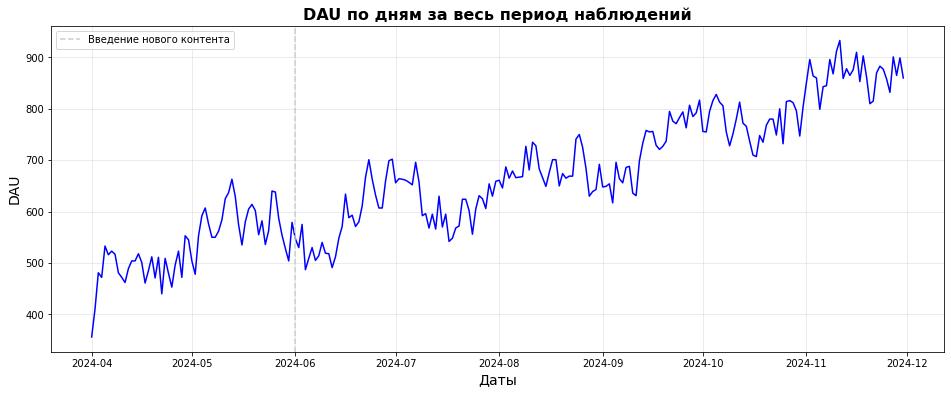

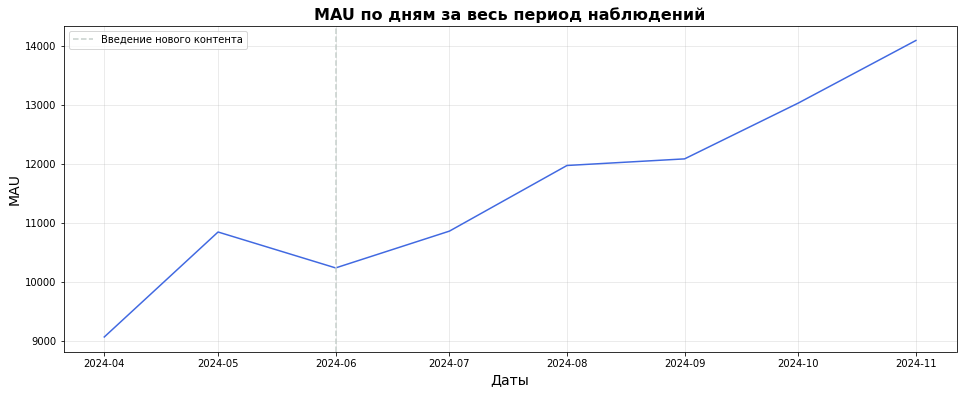

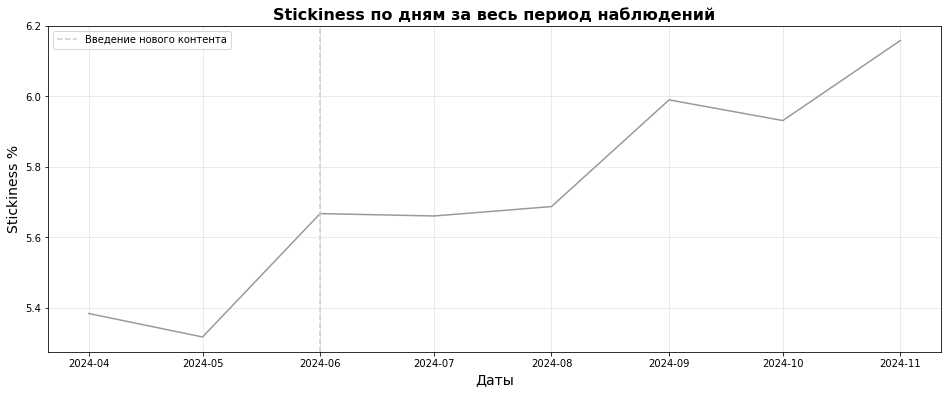

In [19]:
# Проведем визуализацию общих метрик

#DAU
plt.figure(figsize=(16,6))
plt.plot(total_dau['activity_day'].dt.to_timestamp(), total_dau['user_id'], color='#0000ff')
plt.title('DAU по дням за весь период наблюдений', fontsize=16, fontweight='bold')
plt.xlabel('Даты', fontsize=14)
plt.ylabel('DAU', fontsize=14)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента')  
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#MAU
plt.figure(figsize=(16,6))
plt.plot(stickness_total['activity_month'].dt.to_timestamp(), stickness_total['MAU'], color='#4169e1')
plt.title('MAU по дням за весь период наблюдений', fontsize=16, fontweight='bold')
plt.xlabel('Даты', fontsize=14)
plt.ylabel('MAU', fontsize=14)
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#Липкость
plt.figure(figsize=(16,6))
plt.plot(stickness_total['activity_month'].dt.to_timestamp(), stickness_total['stickness'], color='#999999')
plt.title('Stickiness по дням за весь период наблюдений', fontsize=16, fontweight='bold')
plt.xlabel('Даты', fontsize=14)
plt.ylabel('Stickiness %', fontsize=14)
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


#### Вывод графиков активности пользователей:
* Все ключевые метрики вовлеченности пользователей в продукт показывают рост из месяца в месяц
* После введения нового контента метрики вовлеченности показывают более агрессивный рост
* График DAU по дням довольно волатильный, но это в порядках нормы и скорее всего сезонные тренды (выходные и праздничные и т.п.)

### Расчитаем и визуалиируем основные показатели Unit экономики 

In [20]:
filtered_visits = visits[visits['lifetime']<28].copy()
filtered_orders = orders[orders['lifetime']<28].copy()

In [21]:
# Рассчитываем средний САС по месяцам
cac_per_cohorts = profiles.copy()
cac_per_cohorts['interval'] = cac_per_cohorts['first_dt'].dt.to_period('M').dt.to_timestamp()
cac_per_cohorts = cac_per_cohorts.groupby(['interval']).agg(
    total_users=('user_id', 'nunique'),
    avg_cac=('cac', 'mean'),
).reset_index()

# Оставляем покупки, совершенные в первые 28 дней
ltv_per_channel = filtered_orders.copy()
# Выделяем месяц привлечения:
ltv_per_channel['interval'] = ltv_per_channel['first_dt'].dt.to_period('M').dt.to_timestamp()
# Считаем выручку с пользователей за каждый месяц (по месяцу привлечения)
ltv_per_channel = ltv_per_channel.groupby(['interval', 'lifetime']).agg(
    revenue_28=('revenue', 'sum'),
).reset_index()
# Добавляем размер когорт и САС
ltv_per_channel = ltv_per_channel.merge(cac_per_cohorts, on='interval')
# Считаем LTV на 28 день
ltv_per_channel['cumsum_revenue'] = ltv_per_channel.groupby('interval')['revenue_28'].cumsum()
ltv_per_channel['LTV'] = ltv_per_channel['cumsum_revenue'] / ltv_per_channel['total_users']
# Рассчитаем ROI за 28 дней
ltv_per_channel['ROI'] = (ltv_per_channel['LTV'] - ltv_per_channel['avg_cac']) / ltv_per_channel['avg_cac']
ltv_per_channel['ROI_percent'] = (ltv_per_channel['LTV'] - ltv_per_channel['avg_cac']) / ltv_per_channel['avg_cac'] *100
ltv_per_channel.head()

,interval,lifetime,revenue_28,total_users,avg_cac,cumsum_revenue,LTV,ROI,ROI_percent
0,2024-04-01,0,1925.819946,9069,0.734706,1925.819946,0.212352,-0.710970,-71.097031
1,2024-04-01,1,787.820007,9069,0.734706,2713.639893,0.299222,-0.592733,-59.273322
2,2024-04-01,2,508.540009,9069,0.734706,3222.179932,0.355296,-0.516411,-51.641083
3,2024-04-01,3,371.940002,9069,0.734706,3594.119873,0.396308,-0.460590,-46.058958
4,2024-04-01,4,337.559998,9069,0.734706,3931.679932,0.433530,-0.409928,-40.992810


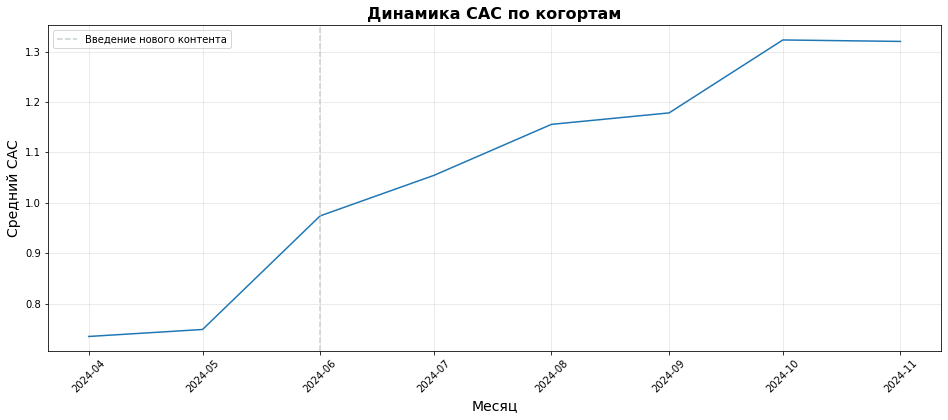

In [22]:
# Визуализируем общий CAC
plt.figure(figsize=(16,6))
cac_df = ltv_per_channel.copy()
cac_df['interval'] = cac_df['interval'].dt.to_period('M')
cac_info_ttl = cac_df.groupby('interval')['avg_cac'].mean().reset_index()
plt.plot(cac_info_ttl['interval'].dt.to_timestamp(), cac_info_ttl['avg_cac'])

plt.xticks(rotation=45)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Средний CAC', fontsize=14)
plt.title('Динамика CAC по когортам', fontsize=16, fontweight='bold')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### График CAC:
* Средняя стоимость привлечения пользователей для когорт после запуска нового контента показывает рост с 0.75 в мае до 0.95 в июне и 1.3 в ноябре

In [23]:
# Уберем ноябрьскую когорту, т.к она не содержит полные данные
unit_df = ltv_per_channel[ltv_per_channel['interval']!='2024-11-01'].copy()
unit_df['interval'] = unit_df['interval'].dt.to_period('M')

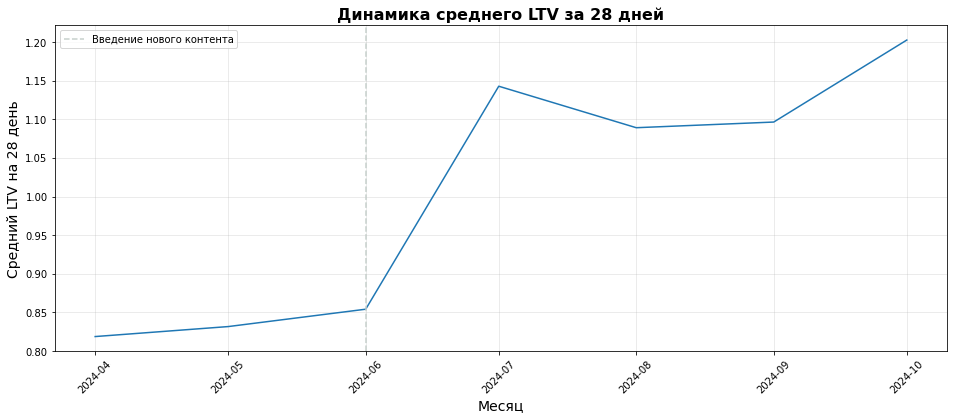

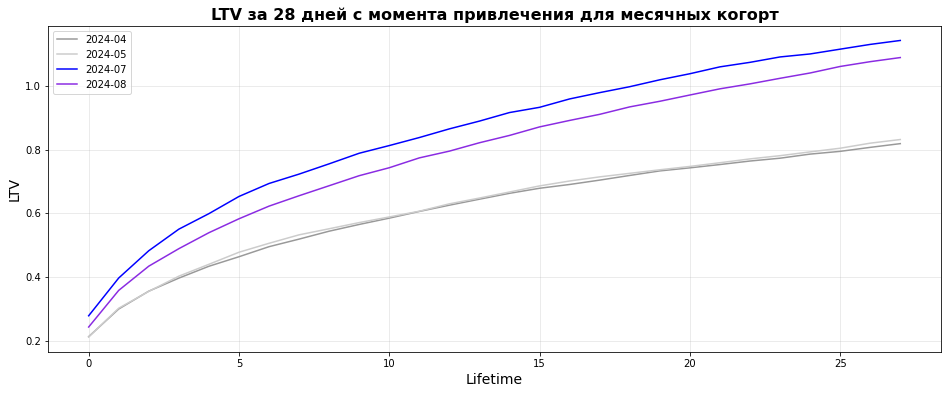

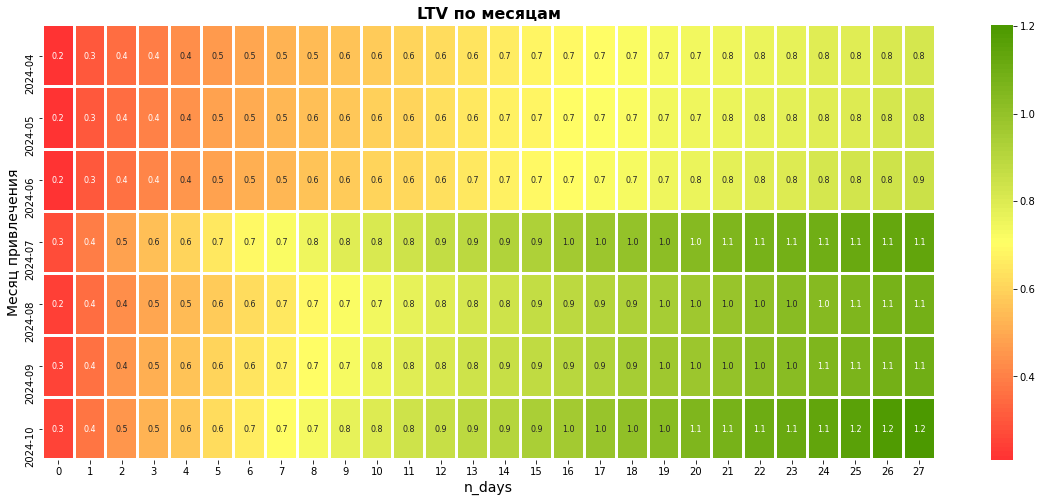

In [24]:
# Визуализируем LTV для когорт до изменения контента и после
# Визуализируем общий LTV
ltv_info_ttl = unit_df[unit_df['lifetime'] == 27]
plt.figure(figsize=(16,6))
plt.plot(ltv_info_ttl['interval'].dt.to_timestamp(), ltv_info_ttl['LTV'])

plt.xticks(rotation=45)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Средний LTV на 28 день', fontsize=14)
plt.title('Динамика среднего LTV за 28 дней', fontsize=16, fontweight='bold')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Визуализируем общий LTV по нескольким когортам
cohorts = {'2024-04':'#999999', '2024-05':'#cccccc', '2024-07':'#0000ff', '2024-08':'#8a2be2'}

plt.figure(figsize=(16,6))
for cohort, color in cohorts.items():
    plt_df = unit_df[unit_df['interval']==cohort]
    plt.plot(plt_df['lifetime'], plt_df['LTV'], color=color, label=cohort)

plt.title('LTV за 28 дней с момента привлечения для месячных когорт', fontsize=16, fontweight='bold')
plt.xlabel('Lifetime', fontsize=14)
plt.ylabel('LTV', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Визуализируем общий LTV по всем
df_pivot = unit_df.pivot(index='interval', columns='lifetime', values='LTV')

df_pivot[df_pivot == 0] = float('nan')

cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

plt.figure(figsize=(20, 8))
sns.heatmap(df_pivot,
           cmap=cmap,
           annot=True,
           fmt='.1f',
           linewidths=2,
           annot_kws={"size": 8})

plt.title('LTV по месяцам', fontsize=16, fontweight='bold')
plt.xlabel('n_days', fontsize=14)
plt.ylabel('Месяц привлечения', fontsize=14)
plt.show()

#### Графики LTV:
* Средний LTV для когорт после введения нового контента показывает рост.

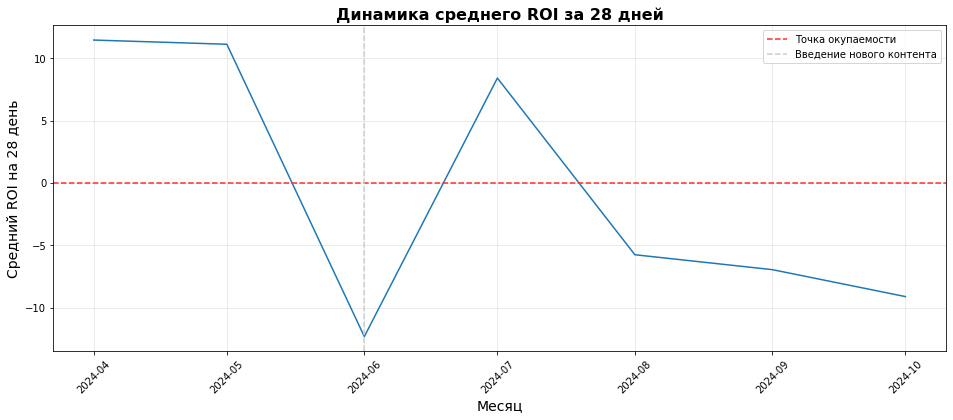

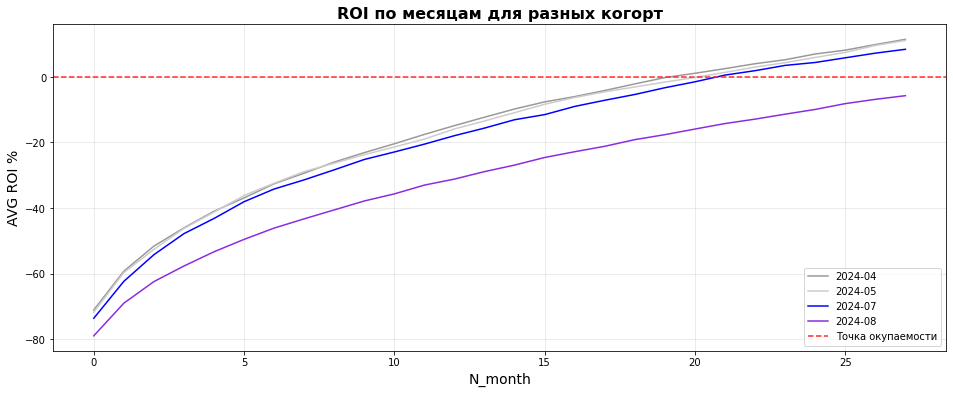

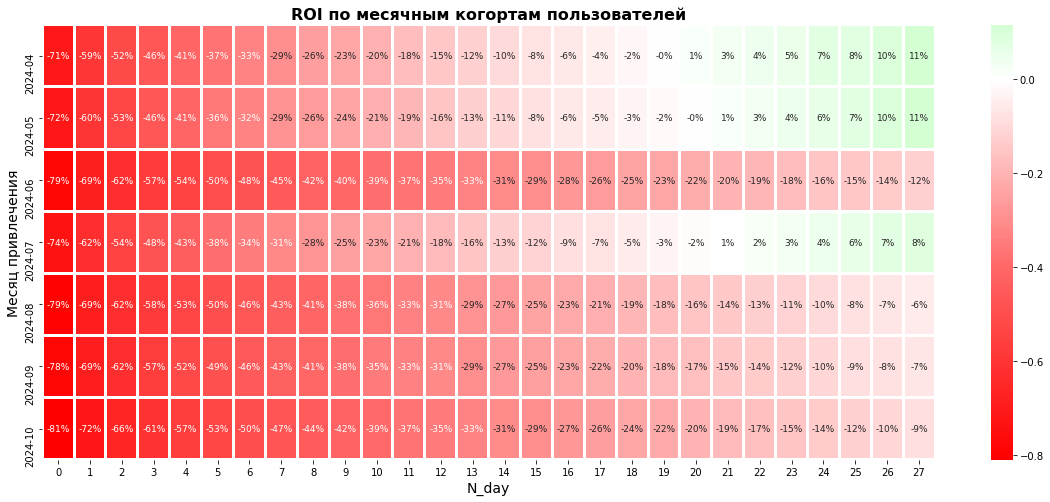

In [25]:
# Проведем расчет ROI и визуализируем его

# Визуализируем общий ROI
plt.figure(figsize=(16,6))
plt.plot(ltv_info_ttl['interval'].dt.to_timestamp(), ltv_info_ttl['ROI_percent'])

plt.xticks(rotation=45)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Средний ROI на 28 день', fontsize=14)
plt.title('Динамика среднего ROI за 28 дней', fontsize=16, fontweight='bold')
plt.axhline(y=0, linestyle='--', color='#ff2b2b', label='Точка окупаемости')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Визуализируем общий LTV по нескольким когортам
cohorts = {'2024-04':'#999999', '2024-05':'#cccccc', '2024-07':'#0000ff', '2024-08':'#8a2be2'}

plt.figure(figsize=(16,6))
for cohort, color in cohorts.items():
    plt_df = unit_df[unit_df['interval']==cohort]
    plt.plot(plt_df['lifetime'], plt_df['ROI_percent'], color=color, label=cohort)
plt.axhline(y=0, linestyle='--', color='#ff2b2b', label='Точка окупаемости')
plt.title('ROI по месяцам для разных когорт', fontsize=16, fontweight='bold')
plt.xlabel('N_month', fontsize=14)
plt.ylabel('AVG ROI %', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Визуализируем общий LTV по всем
df_pivot = unit_df.pivot(index='interval', columns='lifetime', values='ROI')

df_pivot[df_pivot == 0] = float('nan')

cmap = mcolors.LinearSegmentedColormap.from_list(
    'profit_loss_simple',
    [
        '#FF0000',
        '#FF6666',
        '#FFFFFF',
        '#66FF66',
        '#00FF00' 
    ],
    N=256
)

plt.figure(figsize=(20, 8))
sns.heatmap(df_pivot,
          cmap=cmap,
          annot=True,
          fmt='.0%',
          center=0,
          linewidths=2,
          annot_kws={"size": 9})


plt.title('ROI по месячным когортам пользователей', fontsize=16, fontweight='bold')
plt.xlabel('N_day', fontsize=14)
plt.ylabel('Месяц привлечения', fontsize=14)
plt.show()


#### Графики ROI:
* Окупаемость для когорт до введения нового контента наступает в среднем на 18 день
* После введения нового спортивного контента окупаемость не наступает даже на 28 день (таргет окупаемости)
* Исключение когорта 07 месяца. В когорте этого месяца произошел сильный рост LTV и незначительный рост CAC, благодаря этому данная когорта была единственной, которая окупилась после введения контента

### Выводы общего анализа метрик UNIT экономики

* Все ключевые метрики вовлеченности пользователей в продукт показывают рост из месяца в месяц
* После введения нового контента метрики вовлеченности показывают более агрессивный рост
* Средняя стоимость привлечения пользователей для когорт после запуска нового контента увеличивается
* Средний LTV для когорт после введения нового контента, за исключением ноября, показывает положительную динамику
* Окупаемость для когорт до введения нового контента наступает в среднем на 18 день
* После введения нового спортивного контента окупаемость не наступает даже на 28 день (таргет окупаемости)

## Анализ метрик в разрезе источника привлечения

Изучим основные метрики на уровне каждого канала привлечения

### Метрики вовлеченности пользователей

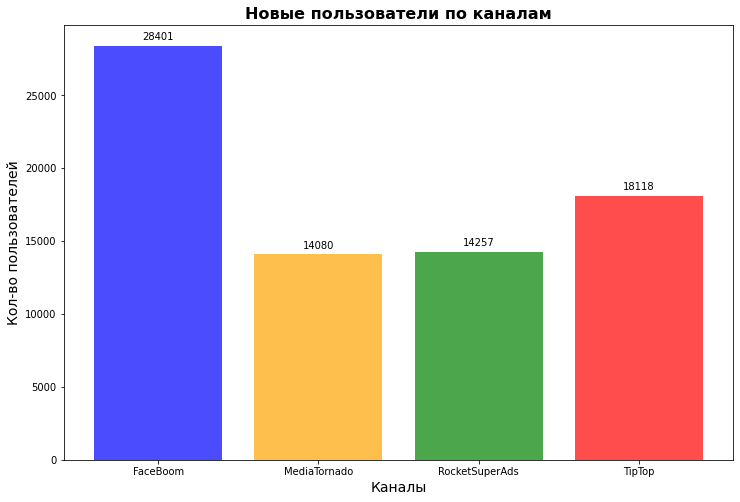

In [26]:
users_channels = profiles.groupby('first_channel')['user_id'].nunique().reset_index()

colors = ['blue', 'orange', 'green', 'red']
colors = [plt.cm.colors.to_rgba(color, alpha=0.7) for color in colors]

plt.figure(figsize=(12,8))
plt.bar(users_channels['first_channel'], users_channels['user_id'], color=colors)

for i, value in enumerate(users_channels['user_id']):
    plt.text(
        i,
        value + max(users_channels['user_id']) * 0.01,
        f'{value:.0f}',
        ha='center', 
        va='bottom', 
        color='black',
        fontsize=10
    )

        
        
plt.title('Новые пользователи по каналам', fontsize=16, fontweight='bold')
plt.xlabel('Каналы', fontsize=14)
plt.ylabel('Кол-во пользователей', fontsize=14)
plt.show()


#### Выводы:
* Больше всего новых пользователей в каналах FaceBoom 28 401 и Tip Top 18 118
* Между двумя оставшимися каналами пользователи распределены примерно одинаково

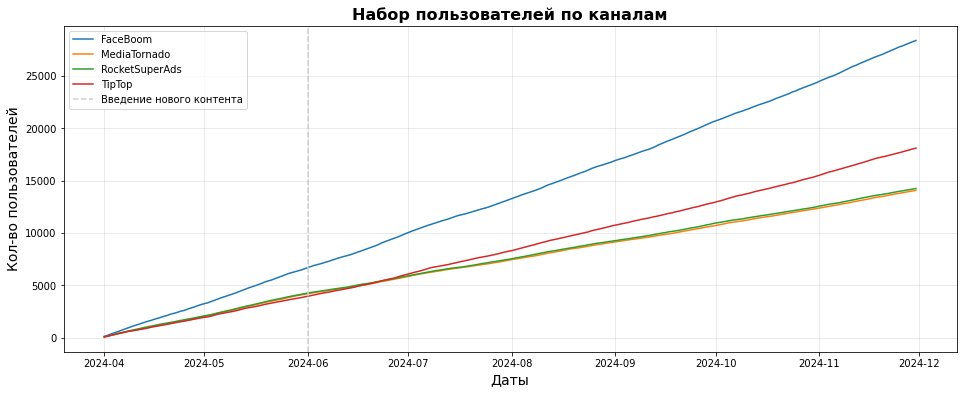

In [27]:
new_users_channel = profiles.groupby(['first_dt','first_channel'])['user_id'].nunique().reset_index()
new_users_channel['user_id'] = new_users_channel.groupby('first_channel').cumsum()

plt.figure(figsize=(16,6))
for channel in new_users_channel['first_channel'].unique():
    plt_df = new_users_channel[new_users_channel['first_channel']==channel]
    plt.plot(plt_df['first_dt'], plt_df['user_id'], label=channel)
plt.title('Набор пользователей по каналам', fontsize=16, fontweight='bold')
plt.xlabel('Даты', fontsize=14)
plt.ylabel('Кол-во пользователей', fontsize=14)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Выводы:
* Набор пользователей по каналам происходит плавно, практически без сильных всплесков после введения нового контента
* В канале FaceBoom набор пользователей показывает более агрессивную динамику после введения нового контента

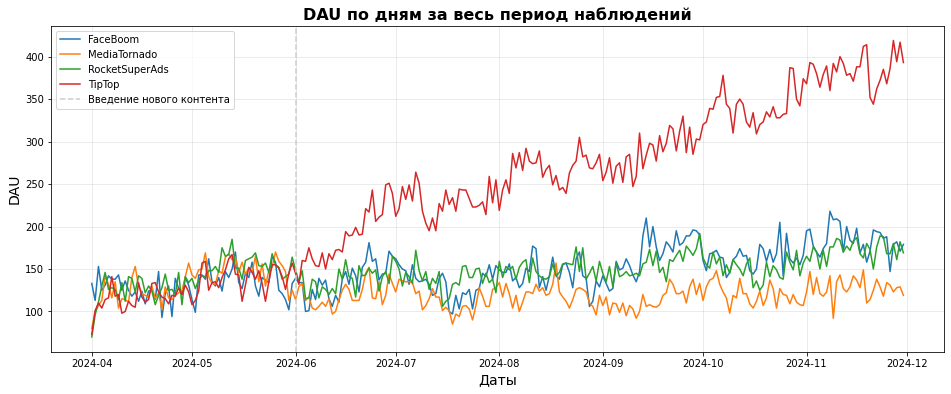

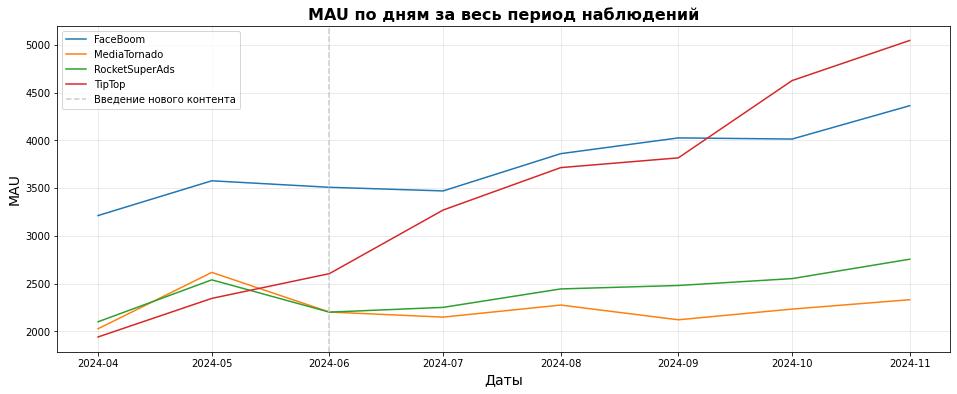

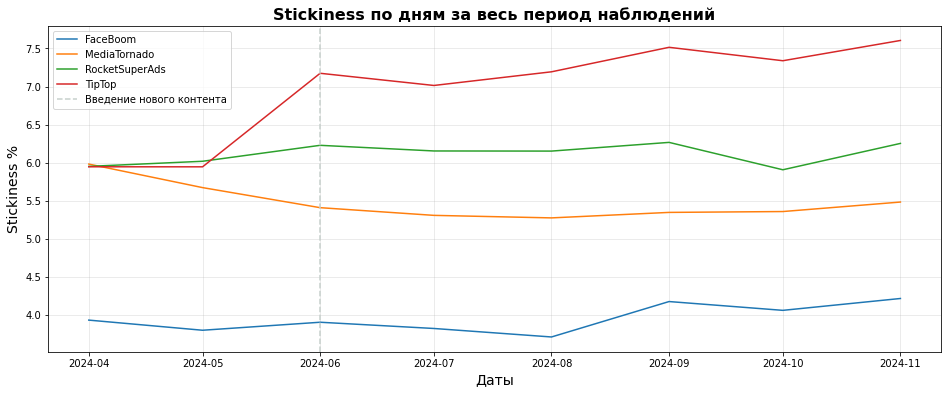

In [28]:
# Проведем визуализацию метрик по каналам привлечения
channels = stickness_channel['channel'].unique()

#DAU
plt.figure(figsize=(16,6))
for channel in channels:
    plt_df = channel_dau[channel_dau['channel']==channel]
    plt.plot(plt_df['activity_day'].dt.to_timestamp(), plt_df['user_id'], label=channel)
plt.title('DAU по дням за весь период наблюдений', fontsize=16, fontweight='bold')
plt.xlabel('Даты', fontsize=14)
plt.ylabel('DAU', fontsize=14)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#MAU
plt.figure(figsize=(16,6))
for channel in channels:
    plt_df = stickness_channel[stickness_channel['channel']==channel]    
    plt.plot(plt_df['activity_month'].dt.to_timestamp(), plt_df['MAU'], label=channel)
plt.title('MAU по дням за весь период наблюдений', fontsize=16, fontweight='bold')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.xlabel('Даты', fontsize=14)
plt.ylabel('MAU', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#Липкость
plt.figure(figsize=(16,6))
for channel in channels:
    plt_df = stickness_channel[stickness_channel['channel']==channel]  
    plt.plot(plt_df['activity_month'].dt.to_timestamp(), plt_df['stickness'], label=channel)
plt.title('Stickiness по дням за весь период наблюдений', fontsize=16, fontweight='bold')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.xlabel('Даты', fontsize=14)
plt.ylabel('Stickiness %', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Выводы:
* DAU по дням и каналам показывает рост
* Основной источник роста - канал Tip Top, который показывает значительный рост после введения спортивного контента
* Остальные каналы в динамике DAU остаются практически без изменений
* MAU по каналам для канала FaceBoom изначительно выше и показывает небольшой рост
* MAU для канала Tip Top после введения нового контента показывает значительный рост
* MAU остальных каналов находится примерно на одном уровне
* Stickiness для канала FaceBoom меньше остальных, данный канал меньше остается в контенте по сравнению с другими
* Stickiness для канала Tip Top вырос после введения нового контента, но далее находится без изменений
* По остальным каналам Stickiness показывает незначительные изменения

### Метрики вовлеченности (Retention + conv в покупку)

In [29]:
visitors = visits.copy()
visitors = visitors[visitors['first_dt']<'2024-10-28']
visitors['first_dt'] = visitors['first_dt'].dt.to_period('W').apply(lambda r: r.start_time)

order = orders.copy()
order = order[order['first_dt']<'2024-10-28']
order['first_dt'] = order['first_dt'].dt.to_period('W').apply(lambda r: r.start_time)


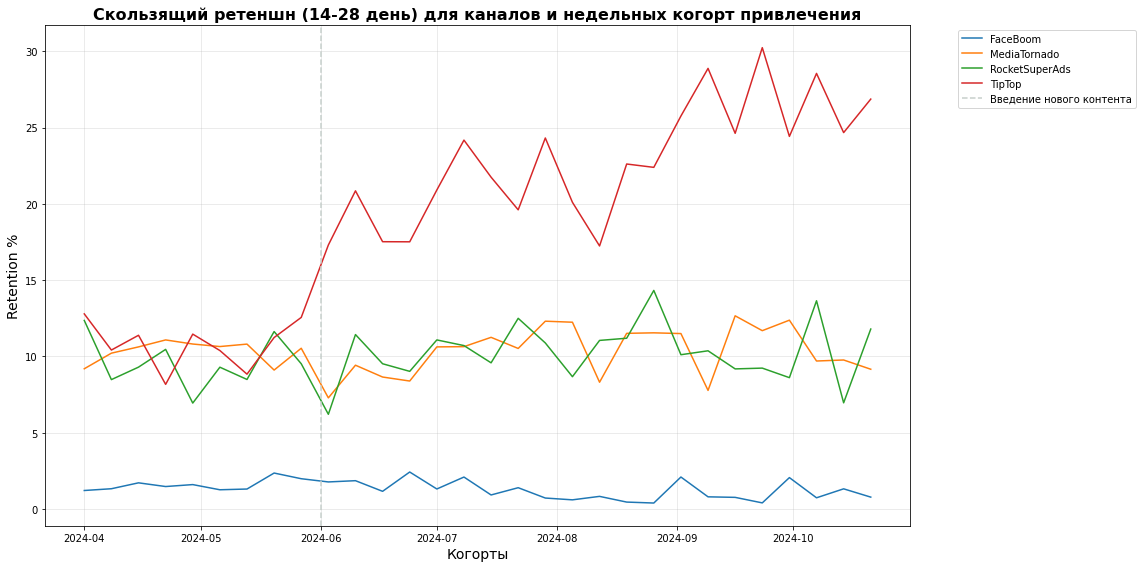

In [30]:
# Расчитаем привлеченных пользователей по каналам
profile = profiles.copy()
profile = profile[profile['first_dt']<'2024-10-28']
profile['first_dt'] = profile['first_dt'].dt.to_period('W').apply(lambda r: r.start_time)

channel_users = profile.groupby(['first_dt', 'first_channel'])['user_id'].nunique().reset_index(name='users')
visitors_slides = visitors[visitors['lifetime'].between(14, 27)].groupby(['first_dt', 'first_channel'])['user_id'].nunique().reset_index(name='visitors')

slide_retention = channel_users.merge(visitors_slides, on=['first_dt', 'first_channel'])
slide_retention['RR'] = slide_retention['visitors']/slide_retention['users'] * 100

plt.figure(figsize=(16,8))
for channel in slide_retention['first_channel'].unique():
    plt_df = slide_retention[slide_retention['first_channel']==channel]    
    plt.plot(plt_df['first_dt'], plt_df['RR'], label=channel)
plt.title('Скользящий ретеншн (14-28 день) для каналов и недельных когорт привлечения', fontsize=16, fontweight='bold')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.xlabel('Когорты', fontsize=14)
plt.ylabel('Retention %', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Выводы:
* Скользящий ретеншн с 14 по 28 день для канала FaceBoom на уровне 1-3%, что является очень низким показателем вовлеченности. После введения нового контента наблюдается тенденция на снижение RR
* Для канала TipTop присущ высокий Ретеншн, который после введения нового контента показывает резкий рост с примерно 12% в мае до 25% в июле и 27 в сентябре
* Для остальных каналов ретеншн на уровне 9%, без роста после введения нового контента

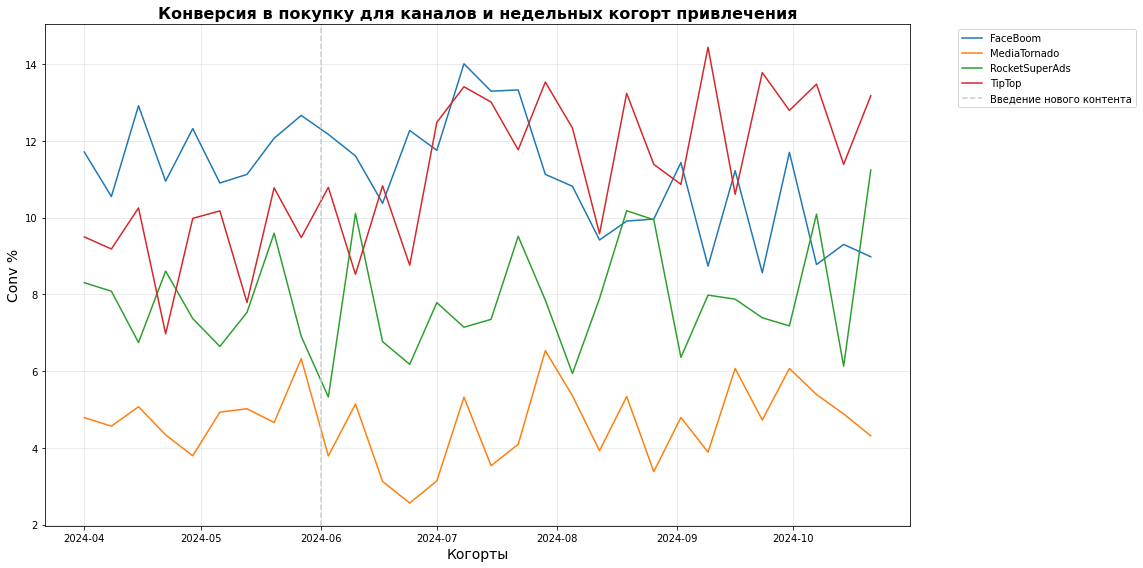

In [31]:
visits_cohort = visitors.groupby(['first_dt', 'first_channel'])['user_id'].nunique().reset_index(name='visitors')
orders_cohort = order.groupby(['first_dt', 'first_channel'])['user_id'].nunique().reset_index(name='byers')

conv_df = visits_cohort.merge(orders_cohort, on=['first_dt', 'first_channel'])
conv_df['conversion'] = conv_df['byers']/conv_df['visitors'] * 100

plt.figure(figsize=(16,8))
for channel in conv_df['first_channel'].unique():
    plt_df = conv_df[conv_df['first_channel']==channel]    
    plt.plot(plt_df['first_dt'], plt_df['conversion'], label=channel)
plt.title('Конверсия в покупку для каналов и недельных когорт привлечения', fontsize=16, fontweight='bold')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.xlabel('Когорты', fontsize=14)
plt.ylabel('Conv %', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Выводы:
* Конверсия в покупку для каналов FaceBoom и Tip Top после введения нового контента в среднем выше 10%
* Конверсия MediaTornado ниже остальных на уровне 3-6%
* После введения нового контента конверсия показывает рост у канала TipTop, у канала FaceBoom наблюдается тенденция на снижение, у остальных каналов конверсия в покупку стабильна


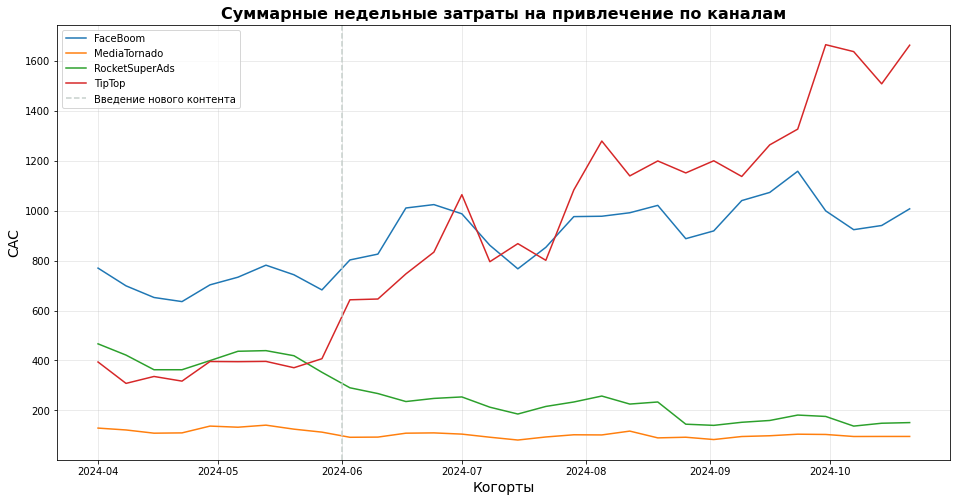

In [32]:
cac_ttl = profile.groupby(['first_dt', 'first_channel'])['cac'].sum().reset_index()

plt.figure(figsize=(16,8))
for channel in conv_df['first_channel'].unique():
    plt_df = cac_ttl[cac_ttl['first_channel']==channel]    
    plt.plot(plt_df['first_dt'], plt_df['cac'], label=channel)
plt.title('Суммарные недельные затраты на привлечение по каналам', fontsize=16, fontweight='bold')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.xlabel('Когорты', fontsize=14)
plt.ylabel('CAC', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Выводы:
* Суммарные затраты для каналов TipTop и FaceBoom показывают рост после введения нового контента. Канал RocketSuperAds показывает тенденцию на снижение затрат на привлечение. Канал mediaTornado находится примерно на одном уровне с небольшим снижением
* Затраты в канале TipTop резко возрасли в 3-4 раза после введения нового контента

### Метрики Unit экономики на уровне источников траффика

In [33]:
# Рассчитываем средний САС
cac_per_channel = profiles.copy()

cac_per_channel['interval'] = cac_per_channel['first_dt'].dt.to_period('W').dt.to_timestamp()

cac_per_channel = cac_per_channel.groupby(['first_channel','interval']).agg(
    total_users = ('user_id','nunique'),
    avg_cac = ('cac','mean'),
).reset_index()

# Оставляем покупки, совершенные в первые 28 дней
ltv_per_channel = orders[orders['lifetime'] < 28].copy()
# Выделяем первый месяц привлечения:
ltv_per_channel['interval'] = ltv_per_channel['first_dt'].dt.to_period('W').dt.to_timestamp()
# Считаем выручку с пользователей за каждый месяц (по месяцу привлечения)
ltv_per_channel = ltv_per_channel.groupby(['first_channel','interval']).agg(
    revenue_28 = ('revenue','sum'),
).reset_index()
# Добавляем размер когорт и САС
ltv_per_channel = ltv_per_channel.merge(cac_per_channel, on=['first_channel','interval'])
# Считаем LTV на 28 день
ltv_per_channel['ltv_28'] = ltv_per_channel['revenue_28'] / ltv_per_channel['total_users']

# Рассчитаем ROI за 28 дней
ltv_per_channel['roi_28'] = (ltv_per_channel['ltv_28'] - ltv_per_channel['avg_cac']) / ltv_per_channel['avg_cac'] *100

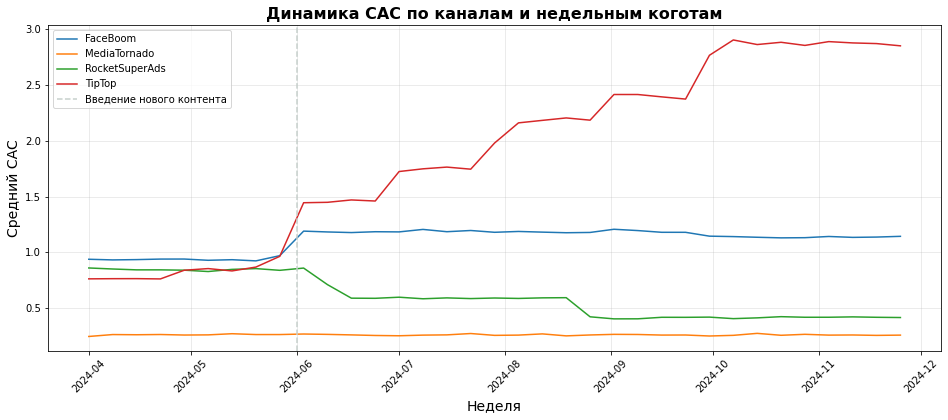

In [34]:
# Визуализируем общий CAC
plt.figure(figsize=(16,6))
for channel in cac_per_channel['first_channel'].unique():
    plt_df = cac_per_channel[cac_per_channel['first_channel'] == channel]
    plt.plot(plt_df['interval'], plt_df['avg_cac'], label=channel)
plt.xticks(rotation=45)
plt.xlabel('Неделя', fontsize=14)
plt.ylabel('Средний CAC', fontsize=14)
plt.title('Динамика CAC по каналам и недельным коготам', fontsize=16, fontweight='bold')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Выводы:
* средний CAC для каналов TipTop и FaceBoom показывает рост после введение нового контента. Стоимость привлечения в канале TipTop показывает сильный рост с 0.7 в мае до 2.7 в ноябре
* Для канала MediaTornado CAC не меняется
* Для канала RocketSuperAds после введения нового контента средний CAC снизился

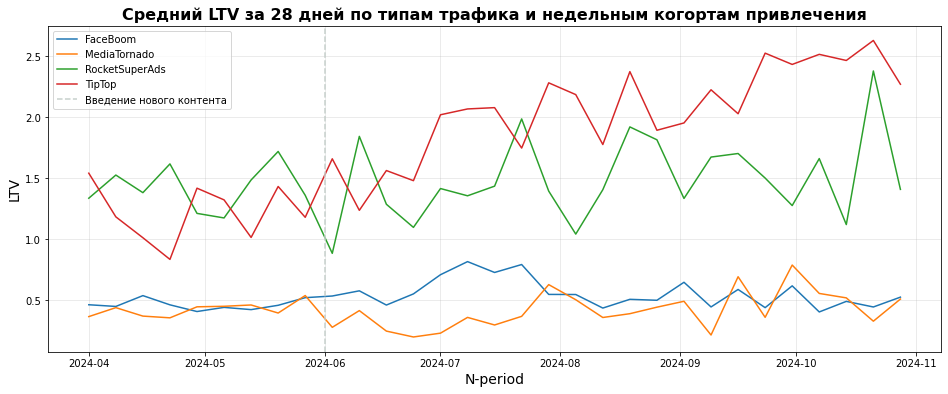

In [35]:
# Визуализируем общий LTV по каналам
plt.figure(figsize=(16,6))
ltv_per_channel = ltv_per_channel[ltv_per_channel['interval'] < '2024-11-01']

for channel in ltv_per_channel['first_channel'].unique():
    plt_df = ltv_per_channel[ltv_per_channel['first_channel'] == channel]
    plt.plot(plt_df['interval'], plt_df['ltv_28'], label=channel)

plt.xlabel('N-period', fontsize=14)
plt.ylabel('LTV', fontsize=14)
plt.title('Средний LTV за 28 дней по типам трафика и недельным когортам привлечения', fontsize=16, fontweight='bold')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

#### Выводы:
* Средний LTV для каналов TipTop и RocketSuperAd показывает рост LTV за первые 28 дней в когортах после введения нового контента
* Для остальных каналов рост довольно незначительный

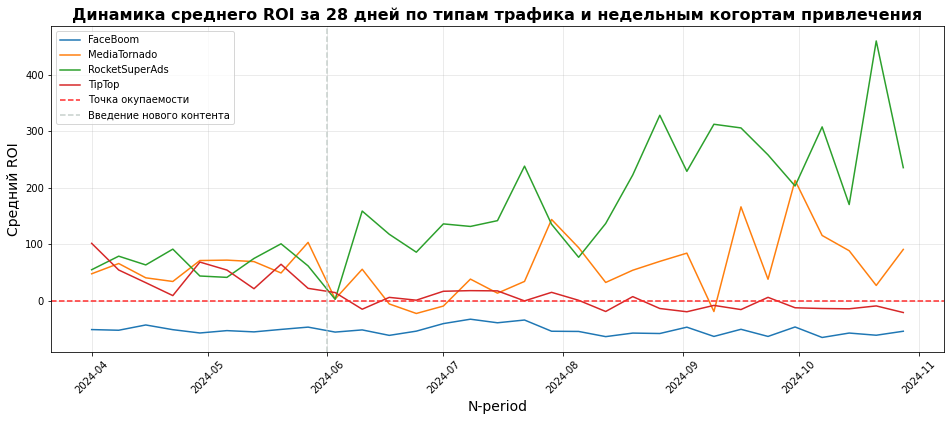

In [36]:
# Визуализируем общий ROI
plt.figure(figsize=(16,6))
for channel in ltv_per_channel['first_channel'].unique():
    plt_df = ltv_per_channel[(ltv_per_channel['first_channel'] == channel)]
    plt.plot(plt_df['interval'], plt_df['roi_28'], label=channel)

plt.xticks(rotation=45)
plt.xlabel('N-period', fontsize=14)
plt.ylabel('Средний ROI', fontsize=14)
plt.title('Динамика среднего ROI за 28 дней по типам трафика и недельным когортам привлечения', fontsize=16, fontweight='bold')
plt.axhline(y=0, linestyle='--', color='#ff2b2b', label='Точка окупаемости')
plt.axvline(x=pd.to_datetime('2024-06'), color='#c7d0cc', linestyle='--', label='Введение нового контента') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


#### Выводы:
* Каналы RocketSuperAds и MediaTornado в большинстве когорт окупаются за первые 28 дней. После введения нового контента для этих каналов средний ROI на 28 день вырос в 2-3 раза
* В связи с высокой стоимостью привлечения в канале TipTop ее окупаемость на 28 день достигается почти во всех когортах по неделям привлечения и колеблится на уровне 10-50% за первые 28 дней
* Канал FaceBoom не окупается за 28 дней во всех когортах

### Выводы анализа по источникам траффика
* Канал FaceBoom является крупнейшим источником новых пользователей (28 401 пользователь), что более чем в 1.5 раза превышает объем привлечения второго по значимости канала Tip Top (18 118 пользователей)
* Наиболее перспективным каналом с точки зрения вовлеченности и удержания пользователей является Tip Top. После введения спортивного контента этот канал показал значительный рост DAU, MAU и Stickiness. Его скользящий ретеншн находится на высоком уровне 18–27%, что выше остальных.
* Канал FaceBoom, несмотря на большой объем привлечения, демонстрирует крайне низкие показатели удержанияи липкости. Пользователи этого канала значительно меньше вовлекаются в контент и быстро отваливаются.
* Каналы RocketSuperAds и MediaTornado показывают стабильный, но умеренный уровень удержания (около 9%) без выраженного роста после введения нового контента.
* Лидерами по конверсии пользователей в покупку являются два крупнейших канала: FaceBoom 11.6% и Tip Top 10.3%. После введения нового контента конверсия Tip Top выросла, тогда как у FaceBoom наметилась тенденция к снижению.
* Стоимость привлечения (CAC) после введения нового контента значительно выросла в каналах Tip Top (с ~0.7 до 2.7 к ноябрю) и FaceBoom. Для RocketSuperAds, напротив, средний CAC снизился, а для MediaTornado остался без изменений.
* LTV за первые 28 дней наиболее выраженный рост демонстрируют пользователи каналов Tip Top и RocketSuperAds.
* В связи с высокой стоимостью привлечения в канале TipTop ее окупаемость на 28 день достигается почти во всех когортах по неделям привлечения и колеблится на уровне 10-50% за первые 28 дней
* Канал FaceBoom не окупается в течение 28-дневного периода из-за сочетания низкого ретеншна и высокого CAC.
* Каналы RocketSuperAds и MediaTornado окупаются за первые 28 дней, а после введения нового контента их средний ROI вырос в 2–3 раза.

## Анализ периода окупаемости маркетинговых вложений

Изучим окупаемость канала FaceBoom и TipTop на более длительном периоде (10 недель)

In [37]:
# Рассчитываем средний САС по месяцам
visits['lifetime'] = visits['lifetime']//7 +1
orders['lifetime'] = orders['lifetime']//7 +1


cac_per_cohorts = profiles.copy()
cac_per_cohorts['interval'] = cac_per_cohorts['first_dt'].dt.to_period('W').dt.to_timestamp()
cac_per_cohorts = cac_per_cohorts.groupby(['first_channel', 'interval']).agg(
    total_users=('user_id', 'nunique'),
    avg_cac=('cac', 'mean'),
).reset_index()

# Оставляем покупки, совершенные в первые 28 дней
ltv_per_channel = filtered_orders.copy()
# Выделяем месяц привлечения:
ltv_per_channel['interval'] = ltv_per_channel['first_dt'].dt.to_period('W').dt.to_timestamp()
# Считаем выручку с пользователей за каждый месяц (по месяцу привлечения)
ltv_per_channel = ltv_per_channel.groupby(['first_channel', 'interval', 'lifetime']).agg(
    revenue_28=('revenue', 'sum'),
).reset_index()
# Добавляем размер когорт и САС
ltv_per_channel = ltv_per_channel.merge(cac_per_cohorts, on=['first_channel', 'interval'])
# Считаем LTV на 28 день
ltv_per_channel['cumsum_revenue'] = ltv_per_channel.groupby('interval')['revenue_28'].cumsum()
ltv_per_channel['LTV'] = ltv_per_channel['cumsum_revenue'] / ltv_per_channel['total_users']
# Рассчитаем ROI за 28 дней
ltv_per_channel['ROI'] = (ltv_per_channel['LTV'] - ltv_per_channel['avg_cac']) / ltv_per_channel['avg_cac']
ltv_per_channel = ltv_per_channel[ltv_per_channel['interval']<'2024-11-01']
ltv_per_channel = ltv_per_channel[(ltv_per_channel['first_channel'].isin(['FaceBoom', 'TipTop'])) & (ltv_per_channel['lifetime']<=9)]

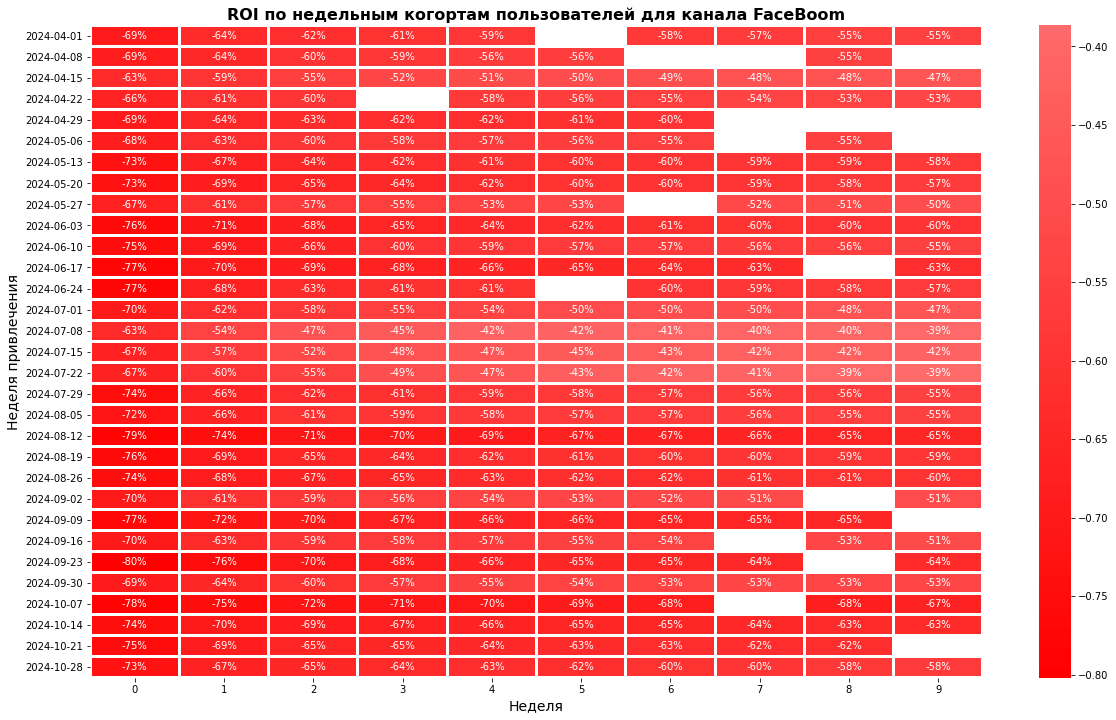

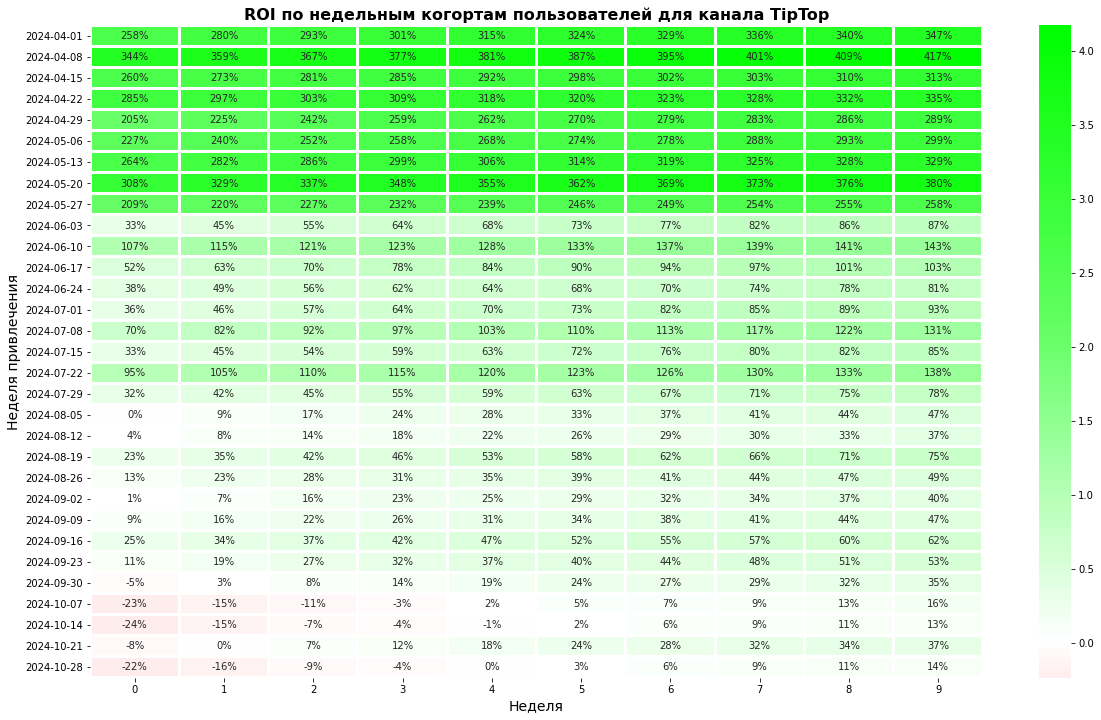

In [38]:
# Визуализируем общий LTV по каналам
ltv_per_channel['interval'] = ltv_per_channel['interval'].dt.strftime('%Y-%m-%d')
for channel in ltv_per_channel['first_channel'].unique():
    plt_df = ltv_per_channel[ltv_per_channel['first_channel'] == channel]
    df_pivot = plt_df.pivot(index='interval', columns='lifetime', values='ROI')
    df_pivot[df_pivot == 0] = float('nan')

    cmap = mcolors.LinearSegmentedColormap.from_list(
        'profit_loss_simple',
        [
            '#FF0000',
            '#FF6666',
            '#FFFFFF',
            '#66FF66',
            '#00FF00' 
        ],
        N=256
    )

    plt.figure(figsize=(20, 12))
    sns.heatmap(df_pivot,
              cmap=cmap,
              annot=True,
              fmt='.0%',
              center=0,
              linewidths=2,
              annot_kws={"size": 10})


    plt.title(f'ROI по недельным когортам пользователей для канала {channel}', fontsize=16, fontweight='bold')
    plt.xlabel('Неделя', fontsize=14)
    plt.ylabel('Неделя привлечения', fontsize=14)
    plt.show()

#### Выводы:
* Канал FaceBoom не окупается даже на 10 неделю
* Для более поздних когорт TipTop по датам привлечения, которые не вышли на окупаемость за 28 дней, самоокупаемость происходит на 5-6 неделю

## Выводы и рекомендации


**Выводы:**
* Введение спортивного контента в начале лета сильно повлияло на метрики продукта. Общие метрики вовлеченности (DAU, MAU, Stickiness) продемонстрировали сильный рост, что подтверждает положительный отклик аудитории. 
* Рост пользователей повлиял на другие метрики Unit экономики - для введения нового контента стало привлекаться больше пользователей - средний CAC начал расти, а целевой период окупаемости (28 дней) для новых пользователей в некоторых каналах перестал достигаться.
* FaceBoom канал с большим охватом и хорошей конверсией в покупку 11.6%.У данного канала очень низкий ретеншн 1.2%. Пользователи с этого канала приходят в продукт, но не остаются. из-за этого окупаемость не наступает даже на 10 неделю, при таргете 28 дней.
* Tip Top канал с высоким ретеншн 18.5% и DAU, MAU. После введения контента показал резкий рост CAC с 0.7 до 2.7, что отодвигает окупаемость ля более поздних когорт на 5-6 неделю. Большинство когорт этого канала окупаются на 28 день
* RocketSuperAds и MediaTornado  стабильные каналы с низким траффиком, которые быстро окупаются, но их вклад в экономику незначителен.

**Рекомендации:**
* Рассмотреть возможность частичного перераспределения инвестиций из канала FaceBoom в другие поттенциальные каналы (MediaTornado и RocketSuperAds) и пересмотреть стратегию привлечения пользователей и таргетинг в этом канале
* Рассмотреть увеличение финансирования в RocketSuperAds - с конверсией в 7.8%, ростом LTV  и высокой окупаемостью это потенциальный канал для привлечения новой платящей аудитории
* Проанализировать рост CAC в канале TipTop и рассмотреть возможность оптимизации стоимости привлечения пользователей этого канала.
* Для канала MediaTornado провести анализ рекламы, у канала низкая конверсия, которая влияет на низкий LTV.